In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
class BondExpansionEstimator(nn.Module):
    def __init__(self, input_size, hidden_layers, check_weights = True):
        super(BondExpansionEstimator, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.check_weights = check_weights
        self.hidden1 = nn.Linear(input_size, hidden_layers[0])
        self.hidden2 = nn.Linear(hidden_layers[0], 1)

    def forward(self, x):  
        # Select data related to individual bonds
        seq_len = x.shape[1]
        bond_data = x[:, :, 0:-1]
        reshaped_bond_data = bond_data.view(-1, self.input_size)
        # Assume last column of data is bond weight (fraction of volume)
        vol_fracs = x[:, :, -1]
        # Check the bond weights are well normalized
        if self.check_weights:
            assert torch.any( torch.abs(torch.sum(vol_fracs, dim = 1) - 1) < 1e-5) # TODO: this line not checked
        
        # Run all hidden layers
        out = torch.relu(self.hidden1(reshaped_bond_data))
        out = torch.relu(self.hidden2(out))
        out = out.view(-1, seq_len)
        # Sum all bonds according to their bond fractions
        summed = torch.sum(out*vol_fracs, dim=1)

        return summed.view(-1,1)

class LatticeDistortionEstimator(nn.Module):
    def __init__(self, input_size):
        super(LatticeDistortionEstimator, self).__init__()
        self.input_size = input_size
        self.layer1 = nn.Linear(input_size, 1)

    def forward(self, x):
        # Run all hidden layers
        out = self.layer1(x)

        return out

class CombinedModel(nn.Module):
    def __init__(self, model_a, model_b):
        super(CombinedModel, self).__init__()
        self.model_a = model_a
        self.model_b = model_b

    def forward(self, x1, x2):
        output_a = self.model_a(x1)
        output_b = self.model_b(x2)

        return output_a*output_b


## Test Use of Model with Fake Data

In [ ]:
# Model Parameters
bond_input_size = 48
distortion_input_size = 5
hidden_layers = [5]

# Training Parameters
learning_rate = 0.001
num_epochs = 100

# Create an instance of the AdditiveSequentialModel
expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers, check_weights=False)
distortion_model = LatticeDistortionEstimator(distortion_input_size)
tec_model = CombinedModel(expansion_model, distortion_model)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(tec_model.parameters(), lr=learning_rate)  # That's me!!
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))

# Generate random sequential data for training
data_size = 1000
seq_length = 5
input_data1 = torch.randn(data_size, seq_length, bond_input_size+1)
input_data2 = torch.randn(data_size, distortion_input_size)
target_data = torch.randn(data_size, 1)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = tec_model(input_data1, input_data2)
    print(outputs.shape)
    loss = criterion(outputs, target_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example of using the trained model for prediction
test_input1 = torch.randn(1, seq_length, bond_input_size+1)
test_input2 = torch.randn(1, distortion_input_size)
predicted_output = tec_model(test_input1, test_input2)

print("Input1 shape:", test_input1.shape)
print("Input2 shape:", test_input2.shape)
print("Predicted Output shape:", predicted_output.shape)

## Now Train on Real Data with SGD

## Load in Data

In [3]:
labels_df = pd.read_csv("labels/labels_reduced.csv", index_col=0)
features_df = pd.read_csv("features/features.csv")

# Choose Features
columns_all = features_df.columns[3:-1].to_list()  # ALL FEATURES, exclude file names and bond volume fractions
feature_weights = features_df[features_df.columns[-1]].to_numpy()

# Copy over labels to each bond (just for correlation)
y = list()
combined_data = list()
weights = list()
labels_skipped = 0
max_length = 0
for idx in labels_df.index:
    phase = labels_df.loc[idx, 'phase_id']
    feat = features_df[features_df['structure_name'] == str(int(phase))+'_super.cif']  # Select all rows applicable to 
    if len(feat) > 0:
        weights.append(torch.Tensor(feat['volume_fraction'].values).to(torch.float).view(len(feat),1))
        feat = feat[columns_all]
        feat['temperature'] = labels_df.loc[idx, "temperature"]  # add temperature as a feature
        max_length = max(max_length, len(feat))
        combined_data.append(torch.Tensor(feat.values).to(torch.float))
        y.append( labels_df.loc[idx, "thermal_expansion"] )
    else:
        print("Phases ", phase, " not found in structures")
        labels_skipped += 1

print("Total Number of Labels: ", len(labels_df))
print("Skipped {} structures".format(labels_skipped))
# Recast y as a torch tensor
y = torch.Tensor(y)
y = y.view(-1,1)

Phases  13996.0  not found in structures
Phases  131156.0  not found in structures
Phases  130566.0  not found in structures
Phases  130566.0  not found in structures
Phases  71777.0  not found in structures
Phases  71777.0  not found in structures
Phases  71776.0  not found in structures
Phases  71776.0  not found in structures
Phases  142888.0  not found in structures
Phases  127780.0  not found in structures
Phases  122321.0  not found in structures
Phases  122321.0  not found in structures
Phases  59916.0  not found in structures
Phases  9782.0  not found in structures
Phases  12354.0  not found in structures
Phases  70111.0  not found in structures
Phases  70110.0  not found in structures
Phases  70180.0  not found in structures
Phases  70109.0  not found in structures
Phases  70109.0  not found in structures
Phases  77642.0  not found in structures
Phases  128280.0  not found in structures
Phases  70179.0  not found in structures
Phases  15966.0  not found in structures
Phases  1

In [4]:
## Pad Data
X = pad_sequence(combined_data, batch_first=True)
X_weights = pad_sequence(weights, batch_first=True)

# Normalize the Data
X = F.normalize(X, p=2, dim=(0,1))
X = torch.cat((X, X_weights), dim=2)

In [ ]:
# Save tensors to a file
torch.save({'X': X, 'y': y}, 'features/data_tensors.pth')

## Create and Train Model

In [3]:
# Load tensors from the file
loaded_data = torch.load('features/data_tensors.pth')
X = loaded_data['X']
y = loaded_data['y']
y = y.view(-1,1)   # TODO: Run cell before this and delete this row

In [56]:
# Model Parameters
bond_input_size = len(X[0][0])-1  # Don't count bond length weights
distortion_input_size = 1
hidden_layers = [20]

# Training Parameters
learning_rate = 0.0001
num_epochs = 100
batch_size = 32  # For each training epoch

# Set up Cross Validation with K-Folds
n_splits = 5
fold_num = 0
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_metrics = []

# Structure Descriptions: Fit single parameter for now on ones
# TODO: Add actual features for structure
X_struc = torch.zeros(len(X), distortion_input_size)


# Check GPU Availability
if torch.cuda.is_available():
    print("Available GPU Device:", torch.cuda.get_device_name(0))
else: 
    print("GPU not available, using CPU...")

# Perform k-fold cross-validation
loss_log = list()
for train_index, test_index in kf.split(X):
    fold_num += 1
    
    # Split the data into training and testing sets for this fold
    X_train, X_test = X[train_index, :, :], X[test_index, :, :]
    y_train, y_test = y[train_index,:], y[test_index,:]
    X_struc_train, X_struc_test = X_struc[train_index, :], X_struc[test_index, :]

    # Create a DataLoader to batch out the data for training
    train_dataset = TensorDataset(X_train, X_struc_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create an instance of the model
    expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers)
    distortion_model = LatticeDistortionEstimator(distortion_input_size)
    tec_model = CombinedModel(expansion_model, distortion_model)
    
    # Define a loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(tec_model.parameters(), lr=learning_rate)  # That's me!!
    
    # Train on GPU
    if torch.cuda.is_available():
        tec_model = tec_model.to('cuda')
    
    print("Starting K Fold {} out of {}".format(fold_num, n_splits))
    # Training loop
    losses = list()
    for epoch in range(num_epochs):
        # Feed data to training stack in batches
        for batch_X, batch_X_struc, batch_y in train_loader:
            # Move training to GPU if available
            if torch.cuda.is_available():
                batch_X, batch_X_struc, batch_y = batch_X.to('cuda'), batch_X_struc.to('cuda'), batch_y.to('cuda')

            # Forward pass
            outputs = tec_model(batch_X, batch_X_struc)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Record loss to make convergence plots
            losses.append(loss.item())
        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
    loss_log.append(losses)
    
    # Evaluate the model on the test set for this fold
    tec_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            X_test, X_struc_test = X_test.to('cuda'), X_struc_test.to('cuda')
        y_pred = tec_model(X_test, X_struc_test)
        y_pred = y_pred.cpu()

    # Compute the evaluation metric for this fold 
    metric1 = mean_squared_error(y_test.numpy(), y_pred.numpy())
    metric2 = mean_absolute_error(y_test.numpy(), y_pred.numpy())
    fold_metrics.append([metric1, metric2])

    # Clear cache on GPU
    torch.cuda.empty_cache()  
    
# Report Number of Parameters
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))

# Calculate the average performance across all folds
fold_metrics = np.array(fold_metrics)
average_mse = np.mean(fold_metrics[:,0])
average_me = np.mean(fold_metrics[:,1])
print("Average MSE: ", average_mse)
print("Average Absolute Error: ", average_me)
print("Variance in Absolute Error: ", np.var(fold_metrics[:,1]))

Available GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU
Starting K Fold 1 out of 5
Epoch [10/100], Loss: 150.0779
Epoch [20/100], Loss: 116.3911
Epoch [30/100], Loss: 515.0928
Epoch [40/100], Loss: 360.3589
Epoch [50/100], Loss: 166.4347
Epoch [60/100], Loss: 127.7059
Epoch [70/100], Loss: 173.4650
Epoch [80/100], Loss: 178.0630
Epoch [90/100], Loss: 888.7984
Epoch [100/100], Loss: 186.6313
Starting K Fold 2 out of 5
Epoch [10/100], Loss: 331.1270
Epoch [20/100], Loss: 151.0046
Epoch [30/100], Loss: 247.3445
Epoch [40/100], Loss: 98.8598
Epoch [50/100], Loss: 193.0918
Epoch [60/100], Loss: 152.8251
Epoch [70/100], Loss: 226.0575
Epoch [80/100], Loss: 316.5143
Epoch [90/100], Loss: 109.3900
Epoch [100/100], Loss: 837.2240
Starting K Fold 3 out of 5
Epoch [10/100], Loss: 335.8317
Epoch [20/100], Loss: 151.8105
Epoch [30/100], Loss: 206.5002
Epoch [40/100], Loss: 165.5689
Epoch [50/100], Loss: 580.9838
Epoch [60/100], Loss: 485.8663
Epoch [70/100], Loss: 250.2155
Epoch [80/100], Loss: 13

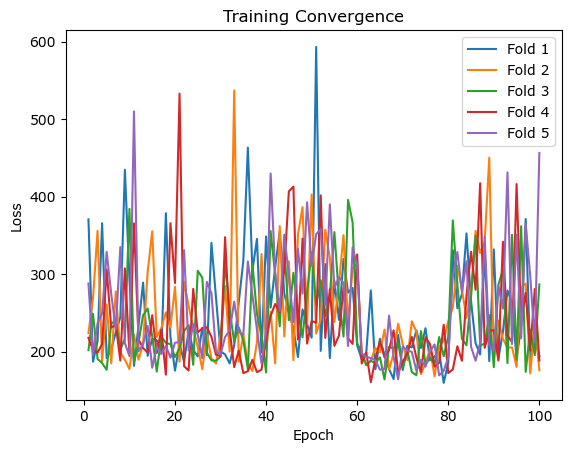

In [59]:
# Graph the Loss after each set of Batches 
loss_log = np.array(loss_log)
loss_len = max(loss_log.shape)
loss_log = loss_log.reshape(loss_len, n_splits)
smoothed_loss = np.array(np.split(loss_log, num_epochs, axis=0))
smoothed_loss = np.median(smoothed_loss, axis=1)

plt.plot(np.arange(1, num_epochs + 1), smoothed_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Convergence')
plt.legend(['Fold {}'.format(i) for i in range(1,n_splits+1)])
plt.show()